In [1]:
import numpy as np
import pandas as pd
import urllib
import os
from bs4 import BeautifulSoup
import re
import pickle
import nltk
import string
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.tokenize import RegexpTokenizer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from collections import Counter
from PIL import Image
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

In [2]:
def loadFile(name):
    directory = str(os.getcwd())
    filepath = os.path.join(directory, name)
    with open(filepath,'r') as f:
        data = f.readlines()
    data = list(set(data))
    result = []
    for d in data:
        d = str(urllib.parse.unquote(d))
        result.append(d)
    return result

In [5]:
badQueries = loadFile("../datasets/badqueries.txt")
goodQueries = loadFile("../datasets/goodqueries.txt")

In [6]:
bad_df = pd.DataFrame(badQueries)
good_df = pd.DataFrame(goodQueries)

In [7]:
bad_df.columns = ["query"]
good_df.columns = ["query"]

In [8]:
bad_df.head()

,query
0,/phorum/plugin/replace/plugin.php?PHORUM[setti...
1,"/t3af3tdz.cfc?<img src=""javascript:alert(cross..."
2,/n1afe1y6.pl?<script>cross_site_scripting.nasl...
3,/member.php?vwar_root=XXpathXX\n
4,/examples/jsp/colors/js/vendors.php?file=../.....


In [9]:
good_df.head()

,query
0,/food-www/\n
1,/031429/\n
2,/000022865/\n
3,/sentguide/\n
4,/vimconfig/\n


In [10]:
text = good_df.loc[0].str
text = text[:-2]
text

query    /food-www
Name: 0, dtype: object

In [11]:
def clean_newline(column):
    column[:-2]
    return column[:-2]

In [12]:
good_df["query"] = good_df["query"].apply(clean_newline)

In [13]:
good_df.head()

,query
0,/food-www
1,/031429
2,/000022865
3,/sentguide
4,/vimconfig


In [14]:
bad_df["query"] = bad_df["query"].apply(clean_newline)

In [15]:
bad_df.head()

,query
0,/phorum/plugin/replace/plugin.php?PHORUM[setti...
1,"/t3af3tdz.cfc?<img src=""javascript:alert(cross..."
2,/n1afe1y6.pl?<script>cross_site_scripting.nasl...
3,/member.php?vwar_root=XXpathX
4,/examples/jsp/colors/js/vendors.php?file=../.....


In [16]:
good_df["label"] = 0
bad_df["label"] = 1

In [17]:
good_df.shape[0] + bad_df.shape[0]

1310707

In [18]:
df = pd.concat([good_df, bad_df], axis=0)

In [19]:
df.shape[0]

1310707

In [20]:
df.head()

,query,label
0,/food-www,0
1,/031429,0
2,/000022865,0
3,/sentguide,0
4,/vimconfig,0


In [21]:
df = df.sample(frac=1).reset_index(drop=True)

In [22]:
df.head()

,query,label
0,/728na90,0
1,/news269,0
2,/icefishinglaketroutlures,0
3,/043856,0
4,/javascript/computers.ls,0


Text(0.5, 1.0, 'MALICIOUS - BENIGN')

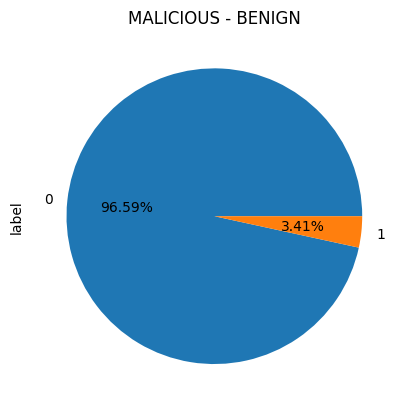

In [23]:
df["label"].value_counts().plot(kind="pie", autopct="%.2f%%").set_title("MALICIOUS - BENIGN")

In [24]:
def clear_first_char(column):
    if column.startswith("/"):
        return column[1:]
    else:
        return column

In [25]:
df["query"] = df["query"].apply(clear_first_char)

In [26]:
df.head()

,query,label
0,728na90,0
1,news269,0
2,icefishinglaketroutlures,0
3,043856,0
4,javascript/computers.ls,0


# Preprocess

In [28]:
def xss_check(input_string):
    xss_pattern = re.compile(r'(<|>|&lt;|&gt;|script|alert|document\.|onload\=|onerror\=|eval\(|expression\(|prompt\(|confirm\()')
    if xss_pattern.search(input_string.split("/")[-1]):
        return 1
    else:
        return 0

In [29]:
df["is_xss"] = df["query"].apply(xss_check)

In [30]:
df[df["is_xss"] == 1].head()

,query,label,is_xss
150,"""><script>alert(1)</script",1,1
196,javascript/alert.p,0,1
218,"lsoix5h3.exe?<img src=""javascript:alert(cross_...",1,1
281,scripta19sm95,1,1
286,"bxnyrhmh.kspx?<script>document.cookie=""testmjc...",1,1


In [31]:
def lfi_check(input_string):
    lfi_pattern = re.compile(r'(file\:\/\/|(\.\.\/)|(\.\.\\))')
    if "=" in input_string.split("/")[-1]:
        if lfi_pattern.search(input_string.split("/")[-1].split("=", 1)[1]):
            return 1
        else:
            return 0
    elif lfi_pattern.search(input_string.split("/")[-1]):
        return 1
    else:
        return 0

In [32]:
"scripts/misc/audio.php?recording=../version.in".split("=", 1)

['scripts/misc/audio.php?recording', '../version.in']

In [33]:
df["is_lfi"] = df["query"].apply(lfi_check)

In [34]:
df[df["is_lfi"] == 1].sample(5)

,query,label,is_xss,is_lfi
395514,pls/sample/admin_/help/..\plsql.con,0,0,1
1068676,..\..\..\..\..\..\..\..\..\..\boot.in,1,0,1
1164759,.\..\.\..\.\..\.\..\.\..\.\..\.\..\{FILE,1,0,1
545363,.\.\.\.\.\.\.\.\.\.\.\.\.\.\.\.\.\.\.\.\.\.\.\...,1,0,1
318719,..\..\\..\..\\..\..\\..\..\\{FILE,1,0,1


In [35]:
def command_injection_check(input_string):
    cmd_injection_pattern = re.compile(r'(;|\||`|\$\(|\$\{)')

    if cmd_injection_pattern.search(input_string):
        return 1
    else:
        return 0

In [36]:
df["is_oci"] = df["query"].apply(command_injection_check)

In [37]:
df[df["is_oci"] == 1].sample(5)

,query,label,is_xss,is_lfi,is_oci
827633,"gy23xnjq.exe?<img src=""javascript:alert(cross_...",1,1,0,1
963123,'|echo EBNPAG$((16+53))$(echo EBNPAG)EBNPAG/,1,0,0,1
558513,"top.php?stuff=""ver;>q48162266&rem",1,1,0,1
168915,%27| [ 1 -ne $(echo FMCMJN | tr -d '\n' | wc -...,1,0,0,1
277718,print(`echo ZHAWPM;echo $((18+57));echo ZHAWPM...,1,0,0,1


In [38]:
def sql_injection_check(input_string):
    sql_injection_pattern = re.compile(r'(\b(SELECT|INSERT|UPDATE|DELETE|FROM|WHERE|AND|OR|UNION|ALL|EXEC|EXECUTE|DECLARE|CAST)\b)')

    if sql_injection_pattern.search(input_string):
        return 1
    else:
        return 0

In [39]:
df["is_sqli"] = df["query"].apply(sql_injection_check)

In [40]:
df[df["is_sqli"] == 1].sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli
224159,x';UPDATE+aa+set+1='2'-,1,0,0,1,1
326261,' OR '1'='1' -,1,0,0,0,1
795569,OR x=x--,1,0,0,0,1
136783,%' AND 8310=8311 AND '%'=,1,0,0,0,1
895148,\x27\x4F\x52 SELECT,1,0,0,0,1


In [41]:
def urllen(url):
    return len(url)

In [42]:
df["url_len"] = df["query"].apply(urllen)

In [43]:
df.head()

,query,label,is_xss,is_lfi,is_oci,is_sqli,url_len
0,728na90,0,0,0,0,0,7
1,news269,0,0,0,0,0,7
2,icefishinglaketroutlures,0,0,0,0,0,24
3,043856,0,0,0,0,0,6
4,javascript/computers.ls,0,0,0,0,0,23


In [45]:
def semicolon_count(url):
    return url.count(";")

In [46]:
df["semicolon_count"] = df["query"].apply(semicolon_count)

In [55]:
df.sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,url_len,semicolon_count,underscore_count
89548,checkcredit,0,0,0,0,0,11,0,0
489211,nav4off,0,0,0,0,0,7,0,0
76009,transparent_console,0,0,0,0,0,19,0,0
510315,20050509-6,0,0,0,0,0,10,0,0
679053,1779020,0,0,0,0,0,7,0,0


In [347]:
def underscore_count(url):
    return url.count("_")

In [349]:
df["underscore_count"] = df["query"].apply(underscore_count)

In [56]:
df.sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,url_len,semicolon_count,underscore_count
674067,article15569,0,0,0,0,0,12,0,0
256560,jtrack3dicon,0,0,0,0,0,12,0,0
758432,uagree,0,0,0,0,0,6,0,0
403921,gemini7,0,0,0,0,0,7,0,0
996356,rfc792icmp,0,0,0,0,0,10,0,0


In [54]:
def questionmark_count(url):
    return url.count("?")

In [58]:
df["questionmark_count"] = df["query"].apply(questionmark_count)

In [59]:
df.sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,url_len,semicolon_count,underscore_count,questionmark_count
180784,j geils band,0,0,0,0,0,12,0,0,0
357635,vng-dfx,0,0,0,0,0,7,0,0,0
1119025,index.php?file_name[]=http://192.168.202.118:8...,0,0,0,0,0,65,0,0,2
179342,post-5337,0,0,0,0,0,9,0,0,0
827257,khagudkl,0,0,0,0,0,8,0,0,0


In [60]:
def equal_count(url):
    return url.count("=")

In [61]:
df["equal_count"] = df["query"].apply(equal_count)

In [62]:
df.sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,url_len,semicolon_count,underscore_count,questionmark_count,equal_count
436543,ors letter 20,0,0,0,0,0,13,0,0,0,0
146736,0465039146,0,0,0,0,0,10,0,0,0,0
1271365,designrk,0,0,0,0,0,8,0,0,0,0
321608,8o0froy23c1078244509,0,0,0,0,0,20,0,0,0,0
44476,ack-standalone,0,0,0,0,0,14,0,0,0,0


In [63]:
def and_count(url):
    return url.count("&")

In [64]:
df["and_count"] = df["query"].apply(equal_count)

In [65]:
df.sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,url_len,semicolon_count,underscore_count,questionmark_count,equal_count,and_count
693115,ipcheck server monitor,0,0,0,0,0,22,0,0,0,0,0
515426,dpyyubfj.asp,0,0,0,0,0,12,0,0,0,0,0
677829,20030701-10,0,0,0,0,0,11,0,0,0,0,0
579233,corp-special,0,0,0,0,0,12,0,0,0,0,0
263622,cyberarmyirc,0,0,0,0,0,12,0,0,0,0,0


In [66]:
def or_count(url):
    return url.count("|")

In [67]:
df["or_count"] = df["query"].apply(or_count)

In [68]:
df.sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,url_len,semicolon_count,underscore_count,questionmark_count,equal_count,and_count,or_count
313280,javascript/dialog.gi,0,0,0,0,0,20,0,0,0,0,0,0
1429,javascript/rules.ym,0,0,0,0,0,19,0,0,0,0,0,0
151209,ibm-442unsealed,0,0,0,0,0,15,0,0,0,0,0,0
324035,javascript/aspx.cf,0,0,0,0,0,18,0,0,0,0,0,0
1079240,betterliving,0,0,0,0,0,12,0,0,0,0,0,0


In [ ]:
df.head()

In [69]:
def dotcount(url):
    return url.count(".")

In [70]:
df["dot_count"] = df["query"].apply(dotcount)

In [72]:
df.sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,url_len,semicolon_count,underscore_count,questionmark_count,equal_count,and_count,or_count,dot_count
476116,dl5789,0,0,0,0,0,6,0,0,0,0,0,0,0
634952,csm_appliance,0,0,0,0,0,13,0,0,0,0,0,0,0
901080,cyborg 009,0,0,0,0,0,10,0,0,0,0,0,0,0
367322,img_0189,0,0,0,0,0,8,0,0,0,0,0,0,0
945958,046034,0,0,0,0,0,6,0,0,0,0,0,0,0


In [73]:
def atcount(url):
    return url.count("@")

In [74]:
df["at_count"] = df["query"].apply(atcount)

In [76]:
df.sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,url_len,semicolon_count,underscore_count,questionmark_count,equal_count,and_count,or_count,dot_count,at_count
481097,300357,0,0,0,0,0,6,0,0,0,0,0,0,0,0
744399,popup-mobile,0,0,0,0,0,12,0,0,0,0,0,0,0,0
926782,mini-glamdring,0,0,0,0,0,14,0,0,0,0,0,0,0,0
699166,blumarrest,0,0,0,0,0,10,0,0,0,0,0,0,0,0
703958,0974514020_thumb,0,0,0,0,0,16,0,0,0,0,0,0,0,0


In [80]:
def subdircount(url):
    parsed_url = urllib.parse.urlparse(url)
    subdirectory_path = len(parsed_url.path.strip("/").split("/"))
    return subdirectory_path

In [81]:
df["subdir_count"] = df["query"].apply(subdircount)

In [82]:
df.sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,url_len,semicolon_count,underscore_count,questionmark_count,equal_count,and_count,or_count,dot_count,at_count,subdir_count
759164,qiyaamexki,0,0,0,0,0,10,0,0,0,0,0,0,0,0,1
788876,wr020801,0,0,0,0,0,8,0,0,0,0,0,0,0,0,1
1250698,\n str=$(echo IKKWEG)\n str1=${#str}\n if [ 6 ...,1,0,0,1,0,89,0,0,0,2,2,0,0,0,1
206358,customized_candies,0,0,0,0,0,18,0,0,0,0,0,0,0,0,1
114813,opinion.in,0,0,0,0,0,10,0,0,0,0,0,0,1,0,1


In [416]:
def query_len(url):
    parsed_url = urllib.parse.urlparse(url)
    if len(parsed_url.query) > 0:
        query_params = urllib.parse.parse_qs(parsed_url.query)
        query_string = "".join(f"{value[0]}" for key, value in query_params.items())    
        return len(query_string)
    else:
        return 0

In [417]:
df["query_len"] = df["query"].apply(query_len)

In [418]:
df.sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,url_len,semicolon_count,underscore_count,questionmark_count,...,url_tokenized,url_stemmed,total_digits_domain,total_letter_domain,total_digits_path,total_letter_path,has_extension,extension,has_parameter,parameters
491568,classes/Auth/OpenID/DumbStore.php?_ENV[asicms]...,1,0,0,0,0,60,0,1,1,...,"[classes, Auth, OpenID, DumbStore, php, ENV, a...",class auth openid dumbstor php env asicm path ...,0,17,0,12,1,.php,1,_ENV[asicms][path]
1227209,dafs_api,0,0,0,0,0,8,0,1,0,...,"[dafs, api]",daf api,0,0,0,7,0,.php,0,
791401,az-logo,0,0,0,0,0,7,0,0,0,...,"[az, logo]",logo,0,0,0,6,0,.php,0,
671692,javascript/output.ta,0,0,0,0,0,20,0,0,0,...,"[javascript, output, ta]",javascript output,0,10,0,8,0,.php,0,
141021,index.php?back=http://192.168.202.118:8080/moc...,0,0,0,0,0,57,0,0,1,...,"[index, php, back, http, moclyxlwqyfjnp]",index php back http moclyxlwqyfjnp,0,0,0,8,1,.php,1,back


In [97]:
def param_count(url):
    parsed_url = urllib.parse.urlparse(url)
    query_params = urllib.parse.parse_qs(parsed_url.query)
    return len(query_params)

In [98]:
df["param_count"] = df["query"].apply(param_count)

In [99]:
df.sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,url_len,semicolon_count,underscore_count,questionmark_count,equal_count,and_count,or_count,dot_count,at_count,subdir_count,query_len,param_count
531944,javascript/weather.a,0,0,0,0,0,20,0,0,0,0,0,0,1,0,2,0,0
954248,virus7,0,0,0,0,0,6,0,0,0,0,0,0,0,0,1,0,0
763039,fierceevents,0,0,0,0,0,12,0,0,0,0,0,0,0,0,1,0,0
1191993,g8nu2yy7.cfm?<script>cross_site_scripting.nasl...,1,1,0,0,0,54,0,0,1,0,0,0,2,0,1,0,0
1043026,javascript/asp.g,0,0,0,0,0,16,0,0,0,0,0,0,1,0,2,0,0


In [100]:
def total_digits_in_url(url):
    total_digits = 0
    for text in list(map(str, "0123456789")):
        total_digits += url.lower().count(text)
        
    return total_digits

In [101]:
df["total_digits_url"] = df["query"].apply(total_digits_in_url)

In [102]:
df.sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,url_len,semicolon_count,underscore_count,questionmark_count,equal_count,and_count,or_count,dot_count,at_count,subdir_count,query_len,param_count,total_digits_url
1283854,1633256,0,0,0,0,0,7,0,0,0,0,0,0,0,0,1,0,0,7
48357,javascript/cs.sq,0,0,0,0,0,16,0,0,0,0,0,0,1,0,2,0,0,0
412107,3652196,0,0,0,0,0,7,0,0,0,0,0,0,0,0,1,0,0,7
1229111,2007 adopt a seat and gift certificate pod,0,0,0,0,0,42,0,0,0,0,0,0,0,0,1,0,0,4
962611,gamehouse-r0,0,0,0,0,0,12,0,0,0,0,0,0,0,0,1,0,0,1


In [103]:
def total_letter_in_url(url):
    total_letter = 0
    for text in url:
        if text not in "0123456789":
            if text not in string.punctuation:
                total_letter += 1
        
    return total_letter

In [104]:
df["total_letter_url"] = df["query"].apply(total_letter_in_url)

In [105]:
tokenizer = RegexpTokenizer(r"[A-Za-z]+")

In [106]:
df["url_tokenized"] = df["query"].apply(lambda x: tokenizer.tokenize(x))

In [107]:
df.sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,url_len,semicolon_count,underscore_count,questionmark_count,...,and_count,or_count,dot_count,at_count,subdir_count,query_len,param_count,total_digits_url,total_letter_url,url_tokenized
660937,effmemorandum522,0,0,0,0,0,16,0,0,0,...,0,0,0,0,1,0,0,3,13,[effmemorandum]
1143271,javascript/second.ph,0,0,0,0,0,20,0,0,0,...,0,0,1,0,2,0,0,0,18,"[javascript, second, ph]"
286043,schattenliunten,0,0,0,0,0,15,0,0,0,...,0,0,0,0,1,0,0,0,15,[schattenliunten]
749757,street-hockey,0,0,0,0,0,13,0,0,0,...,0,0,0,0,1,0,0,0,12,"[street, hockey]"
268749,live-events,0,0,0,0,0,11,0,0,0,...,0,0,0,0,1,0,0,0,10,"[live, events]"


In [108]:
stemmer = SnowballStemmer("english")

In [114]:
def stem_url(column):
    words = [stemmer.stem(word) for word in column if len(word) >= 3]
    return " ".join(words)

In [115]:
df["url_stemmed"] = df["url_tokenized"].apply(stem_url)

In [116]:
df.sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,url_len,semicolon_count,underscore_count,questionmark_count,...,or_count,dot_count,at_count,subdir_count,query_len,param_count,total_digits_url,total_letter_url,url_tokenized,url_stemmed
906427,snapshot2,0,0,0,0,0,9,0,0,0,...,0,0,0,1,0,0,1,8,[snapshot],snapshot
495851,javascript/postnuke.con,0,0,0,0,0,23,0,0,0,...,0,1,0,2,0,0,0,21,"[javascript, postnuke, con]",javascript postnuk con
1297590,computermovies,0,0,0,0,0,14,0,0,0,...,0,0,0,1,0,0,0,14,[computermovies],computermovi
547512,estatebj,0,0,0,0,0,8,0,0,0,...,0,0,0,1,0,0,0,8,[estatebj],estatebj
959537,fw_bison-1,0,0,0,0,0,10,0,0,0,...,0,0,0,1,0,0,1,7,"[fw, bison]",bison


In [245]:
def total_digits_domain(url):
    parsed_url = urllib.parse.urlparse(url)
    clean_url = url.replace(parsed_url.query, "")
    path_components = [component for component in clean_url.split('/') if component]
    if path_components:
        until_last_directory = "".join([word for word in path_components[:-1]])
        return total_digits_in_url(until_last_directory)
    else:
        return 0

In [246]:
df["total_digits_domain"] = df["query"].apply(total_digits_domain)

In [247]:
df.sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,url_len,semicolon_count,underscore_count,questionmark_count,...,query_len,param_count,total_digits_url,total_letter_url,url_tokenized,url_stemmed,total_digits_domain,total_letter_domain,total_digits_path,total_letter_path
1204740,ddeval,0,0,0,0,0,6,0,0,0,...,0,0,0,6,[ddeval],ddeval,0,0,0,6
1168650,javascript/bio.manifes,0,0,0,0,0,22,0,0,0,...,0,0,0,20,"[javascript, bio, manifes]",javascript bio manif,0,10,0,10
752655,sanitarium,0,0,0,0,0,10,0,0,0,...,0,0,0,10,[sanitarium],sanitarium,0,0,0,10
561349,javascript/operations.j,0,0,0,0,0,23,0,0,0,...,0,0,0,21,"[javascript, operations, j]",javascript oper,0,10,0,11
1238409,27bond-ruiters,0,0,0,0,0,14,0,0,0,...,0,0,2,11,"[bond, ruiters]",bond ruiter,0,0,2,11


In [248]:
def total_letter_domain(url):
    parsed_url = urllib.parse.urlparse(url)
    clean_url = url.replace(parsed_url.query, "")
    path_components = [component for component in clean_url.split('/') if component]
    if path_components:
        until_last_directory = "".join([word for word in path_components[:-1]])
        return total_letter_in_url(until_last_directory)
    else:
        return 0

In [249]:
df["total_letter_domain"] = df["query"].apply(total_letter_domain)

In [250]:
df.sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,url_len,semicolon_count,underscore_count,questionmark_count,...,query_len,param_count,total_digits_url,total_letter_url,url_tokenized,url_stemmed,total_digits_domain,total_letter_domain,total_digits_path,total_letter_path
1011504,javascript/functions.ms,0,0,0,0,0,23,0,0,0,...,0,0,0,21,"[javascript, functions, ms]",javascript function,0,10,0,11
130533,javascript/databases,0,0,0,0,0,20,0,0,0,...,0,0,0,19,"[javascript, databases]",javascript databas,0,10,0,9
1220577,examples/jsp/checkbox/search=<script>alert('xs...,1,1,0,0,0,57,0,0,0,...,0,0,0,45,"[examples, jsp, checkbox, search, script, aler...",exampl jsp checkbox search script alert xss sc...,0,39,0,6
31483,136363,0,0,0,0,0,6,0,0,0,...,0,0,6,0,[],,0,0,6,0
1108591,ss_darkgreydot,0,0,0,0,0,14,0,0,0,...,0,0,0,13,"[ss, darkgreydot]",darkgreydot,0,0,0,13


In [251]:
def total_digits_path(url):
    parsed_url = urllib.parse.urlparse(url)
    clean_url = url.replace(parsed_url.query, "")
    path_components = [component for component in clean_url.split('/') if component]
    if path_components:
        last_directory = "".join([word for word in path_components[-1]])
        return total_digits_in_url(last_directory)
    else:
        return total_digits_in_url(clean_url)

In [252]:
df["total_digits_path"] = df["query"].apply(total_digits_path)

In [253]:
df.sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,url_len,semicolon_count,underscore_count,questionmark_count,...,query_len,param_count,total_digits_url,total_letter_url,url_tokenized,url_stemmed,total_digits_domain,total_letter_domain,total_digits_path,total_letter_path
398072,110458,0,0,0,0,0,6,0,0,0,...,0,0,6,0,[],,0,0,6,0
365366,drugs_concern,0,0,0,0,0,13,0,0,0,...,0,0,0,12,"[drugs, concern]",drug concern,0,0,0,12
1052309,news-shop,0,0,0,0,0,9,0,0,0,...,0,0,0,8,"[news, shop]",news shop,0,0,0,8
274478,commentltrfsafees2,0,0,0,0,0,18,0,0,0,...,0,0,1,17,[commentltrfsafees],commentltrfsafe,0,0,1,17
984442,support-mmail,0,0,0,0,0,13,0,0,0,...,0,0,0,12,"[support, mmail]",support mmail,0,0,0,12


In [254]:
def total_letter_path(url):
    parsed_url = urllib.parse.urlparse(url)
    clean_url = url.replace(parsed_url.query, "")
    path_components = [component for component in clean_url.split('/') if component]
    if path_components:
        last_directory = "".join([word for word in path_components[-1]])
        return total_letter_in_url(last_directory)
    else:
        return total_letter_in_url(clean_url)

In [255]:
df["total_letter_path"] = df["query"].apply(total_letter_path)

In [258]:
df.sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,url_len,semicolon_count,underscore_count,questionmark_count,...,query_len,param_count,total_digits_url,total_letter_url,url_tokenized,url_stemmed,total_digits_domain,total_letter_domain,total_digits_path,total_letter_path
879975,vendorcontact,0,0,0,0,0,13,0,0,0,...,0,0,0,13,[vendorcontact],vendorcontact,0,0,0,13
946413,benchmark-stopwatch,0,0,0,0,0,19,0,0,0,...,0,0,0,18,"[benchmark, stopwatch]",benchmark stopwatch,0,0,0,18
979023,wcswiki,0,0,0,0,0,7,0,0,0,...,0,0,0,7,[wcswiki],wcswiki,0,0,0,7
1134929,regexleft,0,0,0,0,0,9,0,0,0,...,0,0,0,9,[regexleft],regexleft,0,0,0,9
967282,hairstraightening,0,0,0,0,0,17,0,0,0,...,0,0,0,17,[hairstraightening],hairstraighten,0,0,0,17


In [265]:
def has_extension(url):
    parsed_url = urllib.parse.urlparse(url)
    query_params = urllib.parse.parse_qs(parsed_url.query)
    path = parsed_url.path
    file_extension = os.path.splitext(path)[1]
    if not query_params or not file_extension:
        return 0
    else:
        return 1

In [266]:
df["has_extension"] = df["query"].apply(has_extension)

In [267]:
df[df["has_extension"] == 1].sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,url_len,semicolon_count,underscore_count,questionmark_count,...,param_count,total_digits_url,total_letter_url,url_tokenized,url_stemmed,total_digits_domain,total_letter_domain,total_digits_path,total_letter_path,has_extension
486912,arash_lib/class/arash_sadmin.class.php?arashli...,0,0,0,0,0,86,0,0,1,...,1,17,52,"[arash, lib, class, arash, sadmin, class, php,...",arash lib class arash sadmin class php arashli...,0,13,0,19,1
258909,load_lang.php?_serweb[serwebdir]=http://192.16...,0,0,0,0,0,73,0,0,1,...,1,17,41,"[load, lang, php, serweb, serwebdir, http, zz,...",load lang php serweb serwebdir http thkvtmlgl,0,0,0,11,1
1007722,stylesheet.php?version=133174949,0,0,0,0,0,32,0,0,1,...,1,9,20,"[stylesheet, php, version]",stylesheet php version,0,0,0,13,1
1037981,"main.php?stuff=""&ver\x0c>q99279396&rem\x0",1,1,0,0,0,41,0,0,1,...,1,10,22,"[main, php, stuff, ver, x, c, q, rem, x]",main php stuff ver rem,0,0,0,7,1
1114942,examples/jsp/sessions/admin/addentry.php?phpbb...,1,0,0,0,0,71,0,0,1,...,1,1,58,"[examples, jsp, sessions, admin, addentry, php...",exampl jsp session admin addentri php phpbb ro...,0,24,0,11,1


In [ ]:
test5 = 'site/relationship_detail.php?name=Martin-Brodeur&celebid=12150&relid=11371' # 0
parsed_url = urllib.parse.urlparse(url)
query_params = urllib.parse.parse_qs(parsed_url.query)
path = parsed_url.path
file_extension = os.path.splitext(path)[1]
if not file_extension:
    return ""
else:
    return file_extension

In [470]:
def find_extension(url):
    parsed_url = urllib.parse.urlparse(url)
    query_params = urllib.parse.parse_qs(parsed_url.query)
    path = parsed_url.path
    file_extension = os.path.splitext(path)[1]
    if not file_extension:
        return ""
    else:
        return file_extension

In [471]:
df["extension"] = df["query"].apply(find_extension)

In [472]:
df[df["has_extension"] == 1].sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,url_len,semicolon_count,underscore_count,questionmark_count,...,url_tokenized,url_stemmed,total_digits_domain,total_letter_domain,total_digits_path,total_letter_path,has_extension,extension,has_parameter,parameters
86683,examples/jsp/jsp2/el/admin/admin.php?sid=0,1,0,0,0,0,42,0,0,1,...,"[examples, jsp, jsp, el, admin, admin, php, sid]",exampl jsp jsp admin admin php sid,1,21,0,8,1,.php,1,sid
102078,administrator/components/com_jim/install.jim.p...,0,0,0,0,0,114,0,3,2,...,"[administrator, components, com, jim, install,...",administr compon com jim instal jim php moscon...,0,29,0,13,1,.php,1,mosconfig_absolute_path
727208,full_release/include/body_comm.inc.php?content...,0,0,0,0,0,86,0,2,1,...,"[full, release, include, body, comm, inc, php,...",full releas includ bodi comm inc php content h...,0,18,0,14,1,.php,1,content
244051,scripts/admin.pl?path=bin/mozilla&action=list_...,1,0,0,0,0,50,0,1,1,...,"[scripts, admin, pl, path, bin, mozilla, actio...",script admin path bin mozilla action list user,0,7,0,7,1,.pl,1,path action
477250,top.php?stuff=ping\x0b-w\x0b11000\x0b-n\x0b1\x...,0,0,0,0,0,62,0,0,1,...,"[top, php, stuff, ping, x, b, w, x, b, x, b, n...",top php stuff ping rem,0,0,0,6,1,.php,1,stuff


In [453]:
def has_parameter(url):
    parsed_url = urllib.parse.urlparse(url)
    if len(parsed_url.query) > 0:
        return 1
    else:
        return 0

In [291]:
df["has_parameter"] = df["query"].apply(has_parameter)

In [292]:
df.sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,url_len,semicolon_count,underscore_count,questionmark_count,...,total_letter_url,url_tokenized,url_stemmed,total_digits_domain,total_letter_domain,total_digits_path,total_letter_path,has_extension,extension,has_parameter
602781,file_extensions,0,0,0,0,0,15,0,0,0,...,14,"[file, extensions]",file extens,0,0,0,14,0,.php,0
1186149,javascript/training.ex,1,0,0,0,0,22,0,0,0,...,20,"[javascript, training, ex]",javascript train,0,10,0,10,0,.php,0
641488,javascript/server-status.wa,0,0,0,0,0,27,0,0,0,...,24,"[javascript, server, status, wa]",javascript server status,0,10,0,14,0,.php,0
1248301,4518503,0,0,0,0,0,7,0,0,0,...,0,[],,0,0,7,0,0,.php,0
263773,javascript/b2b.tes,0,0,0,0,0,18,0,0,0,...,15,"[javascript, b, b, tes]",javascript tes,0,10,1,5,0,.php,0


In [296]:
def find_parameter_name(url):
    parsed_url = urllib.parse.urlparse(url)
    if len(parsed_url.query) > 0:
        query_params = urllib.parse.parse_qs(parsed_url.query)
        query_string = " ".join(f"{key}" for key, value in query_params.items())    
        return query_string
    else:
        return ""

In [297]:
df["parameters"] = df["query"].apply(find_parameter_name)

In [307]:
df.sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,url_len,semicolon_count,underscore_count,questionmark_count,...,url_tokenized,url_stemmed,total_digits_domain,total_letter_domain,total_digits_path,total_letter_path,has_extension,extension,has_parameter,parameters
392604,examples/jsp/cal/data/fetch.php?page=,1,0,0,0,0,37,0,0,1,...,"[examples, jsp, cal, data, fetch, php, page]",exampl jsp cal data fetch php page,0,18,0,8,0,.php,1,
1028841,javascript/loc.rhtm,0,0,0,0,0,19,0,0,0,...,"[javascript, loc, rhtm]",javascript loc rhtm,0,10,0,7,0,.php,0,
1243893,rf_download,0,0,0,0,0,11,0,0,0,...,"[rf, download]",download,0,0,0,10,0,.php,0,
1051952,javascript/access-log.c,0,0,0,0,0,23,0,0,0,...,"[javascript, access, log, c]",javascript access log,0,10,0,10,0,.php,0,
985103,img220,0,0,0,0,0,6,0,0,0,...,[img],img,0,0,3,3,0,.php,0,


In [311]:
df.columns

Index(['query', 'label', 'is_xss', 'is_lfi', 'is_oci', 'is_sqli', 'url_len',
       'semicolon_count', 'underscore_count', 'questionmark_count',
       'equal_count', 'and_count', 'or_count', 'dot_count', 'at_count',
       'subdir_count', 'query_len', 'param_count', 'total_digits_url',
       'total_letter_url', 'url_tokenized', 'url_stemmed',
       'total_digits_domain', 'total_letter_domain', 'total_digits_path',
       'total_letter_path', 'has_extension', 'extension', 'has_parameter',
       'parameters'],
      dtype='object')

In [313]:
features = ['is_xss', 'is_lfi', 'is_oci', 'is_sqli', 'url_len',
       'semicolon_count', 'underscore_count', 'questionmark_count',
       'equal_count', 'and_count', 'or_count', 'dot_count', 'at_count',
       'subdir_count', 'query_len', 'param_count', 'total_digits_url',
       'total_letter_url', 'total_digits_domain', 'total_letter_domain', 
       'total_digits_path', 'total_letter_path', 'has_extension','has_parameter']

In [392]:
df.head()

,query,label,is_xss,is_lfi,is_oci,is_sqli,url_len,semicolon_count,underscore_count,questionmark_count,...,url_tokenized,url_stemmed,total_digits_domain,total_letter_domain,total_digits_path,total_letter_path,has_extension,extension,has_parameter,parameters
0,728na90,0,0,0,0,0,7,0,0,0,...,[na],,0,0,5,2,0,.php,0,
1,news269,0,0,0,0,0,7,0,0,0,...,[news],news,0,0,3,4,0,.php,0,
2,icefishinglaketroutlures,0,0,0,0,0,24,0,0,0,...,[icefishinglaketroutlures],icefishinglaketroutlur,0,0,0,24,0,.php,0,
3,043856,0,0,0,0,0,6,0,0,0,...,[],,0,0,6,0,0,.php,0,
4,javascript/computers.ls,0,0,0,0,0,23,0,0,0,...,"[javascript, computers, ls]",javascript comput,0,10,0,11,0,.php,0,


In [315]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1310707 entries, 0 to 1310706
Data columns (total 30 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   query                1310707 non-null  object
 1   label                1310707 non-null  int64 
 2   is_xss               1310707 non-null  int64 
 3   is_lfi               1310707 non-null  int64 
 4   is_oci               1310707 non-null  int64 
 5   is_sqli              1310707 non-null  int64 
 6   url_len              1310707 non-null  int64 
 7   semicolon_count      1310707 non-null  int64 
 8   underscore_count     1310707 non-null  int64 
 9   questionmark_count   1310707 non-null  int64 
 10  equal_count          1310707 non-null  int64 
 11  and_count            1310707 non-null  int64 
 12  or_count             1310707 non-null  int64 
 13  dot_count            1310707 non-null  int64 
 14  at_count             1310707 non-null  int64 
 15  subdir_count   

# Model

In [511]:
X = df.drop(["query", "label", "url_tokenized", "url_stemmed", "extension", "parameters"], axis=1)
y = df["label"]

In [512]:
ss = StandardScaler()
X_scaled = ss.fit_transform(X)

In [513]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [514]:
X_train.shape

(1048565, 24)

In [517]:
X.head()

,is_xss,is_lfi,is_oci,is_sqli,url_len,semicolon_count,underscore_count,questionmark_count,equal_count,and_count,...,query_len,param_count,total_digits_url,total_letter_url,total_digits_domain,total_letter_domain,total_digits_path,total_letter_path,has_extension,has_parameter
0,0,0,0,0,7,0,0,0,0,0,...,0,0,5,2,0,0,5,2,0,0
1,0,0,0,0,7,0,0,0,0,0,...,0,0,3,4,0,0,3,4,0,0
2,0,0,0,0,24,0,0,0,0,0,...,0,0,0,24,0,0,0,24,0,0
3,0,0,0,0,6,0,0,0,0,0,...,0,0,6,0,0,0,6,0,0,0
4,0,0,0,0,23,0,0,0,0,0,...,0,0,0,21,0,10,0,11,0,0


In [477]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

/home/alper/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [478]:
pred_test = logreg.predict(X_test)

In [479]:
pred_train = logreg.predict(X_train)

In [480]:
train_score = accuracy_score(y_train, pred_train)
print("Train Score: ", train_score)

Train Score:  0.9868210363687516


In [481]:
test_score = accuracy_score(y_test, pred_test)
print("Test Score:", test_score)

Test Score: 0.9865378306414081


In [482]:
pickle.dump(logreg, open("../models/logreg.pkl", "wb"))
pickle.dump(ss, open("../models/logreg_ss.pkl", "wb"))

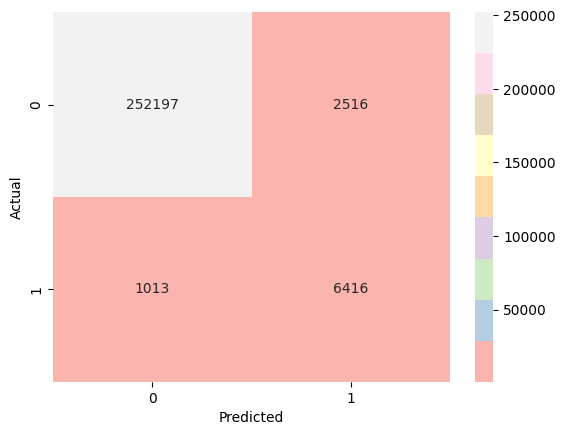

In [483]:
cm = confusion_matrix(pred_test, y_test)
plt.figure()
sns.heatmap(cm, annot=True, cmap="Pastel1", fmt=".0f")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Test

In [484]:
columns = ['query', 'is_xss', 'is_lfi', 'is_oci', 'is_sqli', 'url_len',
       'semicolon_count', 'underscore_count', 'questionmark_count',
       'equal_count', 'and_count', 'or_count', 'dot_count', 'at_count',
       'subdir_count', 'query_len', 'param_count', 'total_digits_url',
       'total_letter_url', 'total_digits_domain', 'total_letter_domain', 
       'total_digits_path', 'total_letter_path', 'has_extension', 'has_parameter']

In [498]:
test1 = 'hrttz9fj.dll?<script>document.cookie="testtbjy=7334;"</script>' # 1
test2 = 'index.php?option=com_mailto&tmpl=component&link=aHR0cDovL2FkdmVudHVyZ' # 1
test3 = 'nba/player/_/id/3457/brandon-rush' # 0
test4 = '?q=anthony-hamilton-soulife' # 0
test5 = 'site/relationship_detail.php?name=Martin-Brodeur&celebid=12150&relid=11371' # 0

In [499]:
test_df = pd.DataFrame(columns=columns)

In [500]:
test_df.loc[0, "query"] = test1
test_df.loc[1, "query"] = test2
test_df.loc[2, "query"] = test3
test_df.loc[3, "query"] = test4
test_df.loc[4, "query"] = test5

In [501]:
test_df.head()

,query,is_xss,is_lfi,is_oci,is_sqli,url_len,semicolon_count,underscore_count,questionmark_count,equal_count,...,query_len,param_count,total_digits_url,total_letter_url,total_digits_domain,total_letter_domain,total_digits_path,total_letter_path,has_extension,has_parameter
0,"hrttz9fj.dll?<script>document.cookie=""testtbjy...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,index.php?option=com_mailto&tmpl=component&lin...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,nba/player/_/id/3457/brandon-rush/q=/etc/passwd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,?q=anthony-hamilton-soulife,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,site/relationship_detail.php?name=Martin-Brode...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [502]:
stemmer = SnowballStemmer("english")
tokenizer = RegexpTokenizer(r"[A-Za-z]+")

In [503]:
def preprocess(test_df):
    test_df["query"] = test_df["query"].apply(clear_first_char)
    test_df["is_xss"] = test_df["query"].apply(xss_check)
    test_df["is_lfi"] = test_df["query"].apply(lfi_check)
    test_df["is_oci"] = test_df["query"].apply(command_injection_check)
    test_df["is_sqli"] = test_df["query"].apply(sql_injection_check)
    test_df["url_len"] = test_df["query"].apply(urllen)
    test_df["semicolon_count"] = test_df["query"].apply(semicolon_count)
    test_df["underscore_count"] = test_df["query"].apply(underscore_count)
    test_df["questionmark_count"] = test_df["query"].apply(questionmark_count)
    test_df["equal_count"] = test_df["query"].apply(equal_count)
    test_df["and_count"] = test_df["query"].apply(and_count)
    test_df["or_count"] = test_df["query"].apply(or_count)
    test_df["dot_count"] = test_df["query"].apply(dotcount)
    test_df["at_count"] = test_df["query"].apply(atcount)
    test_df["subdir_count"] = test_df["query"].apply(subdircount)
    test_df["query_len"] = test_df["query"].apply(query_len)
    test_df["param_count"] = test_df["query"].apply(param_count)
    test_df["total_digits_url"] = test_df["query"].apply(total_digits_in_url)
    test_df["total_letter_url"] = test_df["query"].apply(total_letter_in_url)
    test_df["url_tokenized"] = test_df["query"].apply(lambda x: tokenizer.tokenize(x))
    test_df["url_stemmed"] = test_df["url_tokenized"].apply(stem_url)
    test_df["total_digits_domain"] = test_df["query"].apply(total_digits_domain)
    test_df["total_letter_domain"] = test_df["query"].apply(total_letter_domain)
    test_df["total_digits_path"] = test_df["query"].apply(total_digits_path)
    test_df["total_letter_path"] = test_df["query"].apply(total_letter_path)
    test_df["has_extension"] = test_df["query"].apply(has_extension)
    test_df["extension"] = test_df["query"].apply(find_extension)
    test_df["has_parameter"] = test_df["query"].apply(has_parameter)
    test_df["parameters"] = test_df["query"].apply(find_parameter_name)
    return test_df

In [504]:
test_df = preprocess(test_df)

In [505]:
test_df.head()

,query,is_xss,is_lfi,is_oci,is_sqli,url_len,semicolon_count,underscore_count,questionmark_count,equal_count,...,total_digits_domain,total_letter_domain,total_digits_path,total_letter_path,has_extension,has_parameter,url_tokenized,url_stemmed,extension,parameters
0,"hrttz9fj.dll?<script>document.cookie=""testtbjy...",1,0,1,0,62,1,0,1,2,...,0,0,1,10,1,1,"[hrttz, fj, dll, script, document, cookie, tes...",hrttz dll script document cooki testtbji script,.dll,<script>document.cookie
1,index.php?option=com_mailto&tmpl=component&lin...,0,0,0,0,69,0,1,1,3,...,0,0,0,8,1,1,"[index, php, option, com, mailto, tmpl, compon...",index php option com mailto tmpl compon link a...,.php,option tmpl link
2,nba/player/_/id/3457/brandon-rush/q=/etc/passwd,0,0,0,0,47,0,1,0,1,...,4,26,0,6,0,0,"[nba, player, id, brandon, rush, q, etc, passwd]",nba player brandon rush etc passwd,,
3,?q=anthony-hamilton-soulife,0,0,0,0,27,0,0,1,1,...,0,0,0,0,0,1,"[q, anthony, hamilton, soulife]",anthoni hamilton soulif,,q
4,site/relationship_detail.php?name=Martin-Brode...,0,0,0,0,74,0,1,1,3,...,0,4,0,21,1,1,"[site, relationship, detail, php, name, Martin...",site relationship detail php name martin brode...,.php,name celebid relid


In [506]:
dropped = test_df.drop(["query", "url_tokenized", "url_stemmed", "extension", "parameters"], axis=1)

In [507]:
dropped_scaled = ss.transform(dropped)

In [508]:
logreg.predict(dropped_scaled)

array([1, 0, 0, 0, 0])